# Homework 3: Scraping and Regression
[HackerNews](https://news.ycombinator.com). 
## Part 1 Data Acquisition

Check out the robots.txt file for HN to make sure you're allowed to scrape it for stories.

In [1]:
news.ycombinator.com/robots.txt

NameError: name 'news' is not defined

Grab the first 5 pages of stories from hackernews.  For each story, grab the following data: 

* Rank (the number of the story on hacker news)
* Length of the title
* Age, in hours (note, some stories are days or minutes old.  You should be able to handle this)
* Points (note, some stories don't have scores! Give them 0 points)
* Number of comments (again, some stories have no comments.  Mark them 0)

In [12]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import re
# converts time string into hours as a float
def parse_age(age_str):
    #minutes to hours
    if 'minute' in age_str:
        return int(re.search(r'\d+', age_str).group()) / 60 
    elif 'hour' in age_str:
        return int(re.search(r'\d+', age_str).group())
    #days to hours
    elif 'day' in age_str:
        return int(re.search(r'\d+', age_str).group()) * 24
    return 0

#List to store each story's data
stories = []
#5 pages of Hacker News
for page in range(1, 6):
    #construct the URL for each page
    url = f'https://news.ycombinator.com/news?p={page}'
    #send HTTP GET request
    res = requests.get(url)
    #parse the HTML content
    soup = BeautifulSoup(res.text, 'html.parser')
    #select all story rows
    items = soup.select('.athing')
    
    for item in items:
        #get the story title and compute its length
        title_elem = item.select_one('.titleline > a')
        title = title_elem.get_text() if title_elem else ''
        title_length = len(title)
        #get the story's rank on the page
        rank_elem = item.select_one('.rank')
        rank = int(rank_elem.text.replace('.', '')) if rank_elem else None
        #get the row with metadata (age, score, comments)
        subtext = item.find_next_sibling('tr').select_one('.subtext')
        #extract age and convert to hours
        age_elem = subtext.select_one('.age') if subtext else None
        age = parse_age(age_elem.text) if age_elem else None
        #extract points
        score_elem = subtext.select_one('.score') if subtext else None
        points = int(score_elem.text.replace(' points', '')) if score_elem else 0
        #extract comments
        comment_text = subtext.find_all('a')[-1].text if subtext else '0 comments'
        match = re.search(r'\d+', comment_text)
        comments = int(match.group()) if match else 0
        #store the extracted data in a dictionary
        stories.append({
            'Rank': rank,
            'TitleLength': title_length,
            'AgeHours': age,
            'Points': points,
            'Comments': comments
        })
        
    time.sleep(1)  
#convert the list of stories to df
df = pd.DataFrame(stories)
#remove rows with missing values
df.dropna(inplace=True)
#save to csv file
df.to_csv('hn_stories.csv', index=False)

## Part 2 Regression

We're interested in how to get a high-ranking story on Hackernews.  Explore several possible least squares regressions to predict a story's rank based on the other variables (or combinations thereof).  Include at least 3 different regressions.  Compare/contrast them.  Which is the most useful.  Are there linear relationships between any of the variables?  How about other relationships like inverse linear (1/x)?

In [13]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

df = pd.read_csv('hn_stories.csv')
X = df[['Points', 'Comments', 'AgeHours', 'TitleLength']]
y = df['Rank']

#Linear
lr = LinearRegression().fit(X, y)
print("Linear R^2:", lr.score(X, y))

#Inverse Transform
X_inv = 1 / (X + 1)
lr_inv = LinearRegression().fit(X_inv, y)

#Polynomial
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
lr_poly = LinearRegression().fit(X_poly, y)
print("Poly R^2:", lr_poly.score(X_poly, y))

Linear R^2: 0.4072518963444748
Poly R^2: 0.6023554741024457



## Part 3 Classification

As smart people, we know that your rank on HN doesn't matter, as long as you're on the front page.  Use logistic regression to attempt to classify whether or not an article will be on the front page, given the other (non-rank) variables.  Note, you'll need to transform the rank variable into an indicator variable (1 for front page, 0 for not), for example.  

Include plots showing your regression (for the functions of 1 or 2 variables).  What do your regressions tell you about making the front page?


In [14]:
df['FrontPage'] = (df['Rank'] <= 30).astype(int)
#Transform Rank into binary

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93        30
           1       0.70      0.88      0.78         8

    accuracy                           0.89        38
   macro avg       0.83      0.89      0.85        38
weighted avg       0.91      0.89      0.90        38



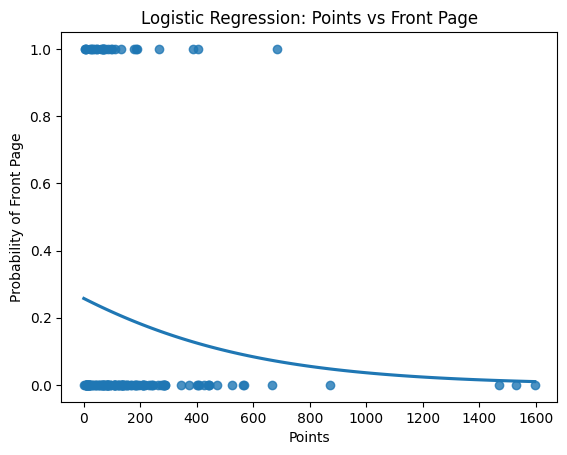

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = df[['Points', 'Comments', 'AgeHours', 'TitleLength']]
y = df['FrontPage']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

clf = LogisticRegression(max_iter=1000).fit(X_train, y_train)
print("Classification Report:\n", classification_report(y_test, clf.predict(X_test)))

#Plot for Points
import seaborn as sns

sns.regplot(x=df['Points'], y=df['FrontPage'], logistic=True, ci=None)
plt.xlabel("Points")
plt.ylabel("Probability of Front Page")
plt.title("Logistic Regression: Points vs Front Page")
plt.show()

## Fun extra challenge

An outdated ranking formula for HN is publicly available.  Take a look at it and perform a regression using the true formula and see if least squraes regression can compute the coefficients correctly

In [17]:
df['ScoreEstimate'] = (df['Points'] - 1) / ((df['AgeHours'] + 2) ** 1.8)

from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(df[['ScoreEstimate']], df['Rank'])

print("R^2 with HN Score formula:", model.score(df[['ScoreEstimate']], df['Rank']))

R^2 with HN Score formula: 0.2491026643858424
